# CPD with B-series data

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob as glob
import ruptures as rpt
from scipy.signal import butter,filtfilt
import scipy.integrate as sint
%matplotlib notebook

In [2]:
"""
Read all Bseries from 2021 data into one big dataframe
Find the path to files in subfolders using os.listdir
"""
def read_B_series_subfolders(path):
    # create a list of file and sub directories 
    # names in the given directory 
    subfolders = os.listdir(path)
    file_list = []
    # Iterate over all the entries
    for names in subfolders:
        # Create full path
        fullPath = os.path.join(path, names)
        # If entry is a directory then get the list of files in this directory 
        temp_path = fullPath#for glob
        if os.path.isdir(fullPath):
            file_list = file_list + read_B_series_subfolders(fullPath)   
        else:
            txt_files = glob.glob(path + "/*.csv")#only read txt files
            if (txt_files != []):
                file_list.append(txt_files)
    return file_list

def read_Bseries_data(path):
    drifter_identifyer = path[85:-4]
    print(drifter_identifyer)
    #column_names = ['time', 'pressure1', 'temp1', 'pressure2', 'temp2',"pressure3","temp3", 'E_x', 'E_y', 'E_z', 'W_w','Q_y', 'Q_z', 'M_x', 'M_y', 'M_z', 'AX_earth', 'AY_earth', 'AZ_earth',"RX","RY","RZ","CSM","CSA","CSR","CSTOT"]
    #indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    df = pd.read_csv(path)
    df.drop(df[abs(df["PL [hPa]"]) > 3000].index, inplace = True)
    df.drop(df[abs(df["PC [hPa]"]) > 3000].index, inplace = True)
    df.drop(df[abs(df["PR [hPa]"]) > 3000].index, inplace = True)
    return df

In [22]:
"""read all 2021 Bseries filenames from folder system"""
path = "/Users/georgecowie/Documents/Master/Masteroppgave/data/Drifters/Supraglacial channel"#common path
"""Read all B series filnames"""
filenames_B = np.array(read_B_series_subfolders(path),dtype=object)
filenames_B = np.unique(filenames_B)#remove duplicate files

# Try low pass filter

2851
2851
(49851, 4)


<IPython.core.display.Javascript object>


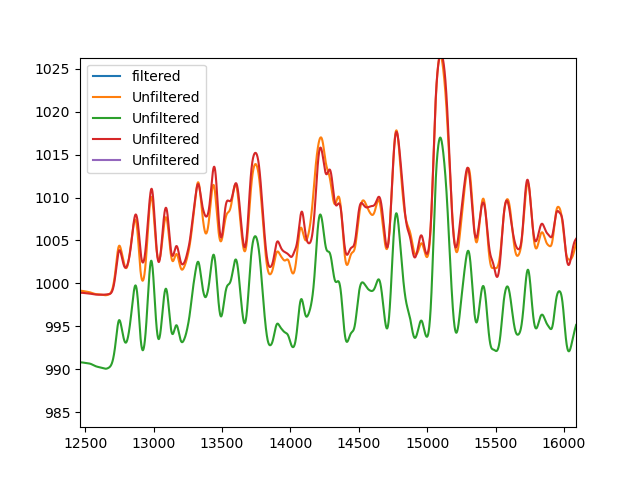

In [41]:
"""Function taken from somehere on the internett"""
#https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



# Sliding window CPD B-series data

In [4]:
def window_cpd(signal,model,width,jump,dim,sigma):
    # change point detection
    model =   model#"ar"
    n = np.shape(signal)[0]
    algo = rpt.Window(model=model, width = width, jump = jump).fit(signal)
    my_bkps = algo.predict(pen=np.log(n) * dim *sigma ** 2)
    rpt.show.display(signal, my_bkps, figsize=(10, 6))
    plt.show()
    print("Number of changepoints: ",len(my_bkps))
    return my_bkps

In [89]:
# generate signal
#15.07 2021 A drone was used to follow drifter M09 at 12:59. Filneme for this deployment: M090715104232.txt

def gen_signal(filename):
    ruptures_df = read_Bseries_data(filename)
    ruptures_df_norm = read_Bseries_data(filename)

    #ruptures_df_norm["acc_abs"] = np.sqrt(ruptures_df["acc_x"]**2 + ruptures_df["acc_x"]**2 + ruptures_df["acc_x"]**2)
    ruptures_df_norm = (ruptures_df_norm-ruptures_df_norm.min())/(ruptures_df_norm.max()-ruptures_df_norm.min())
    signal_norm = ruptures_df_norm[["PL [hPa]","PC [hPa]","PR [hPa]"]].to_numpy()

    #ruptures_df["acc_abs"] = np.sqrt(ruptures_df["acc_x"]**2 + ruptures_df["acc_x"]**2 + ruptures_df["acc_x"]**2)
    signal = ruptures_df[["PL [hPa]","PC [hPa]","PR [hPa]","QX [-]","QY [-]","QZ [-]"]].to_numpy()
    #signal = ruptures_df[["PL [hPa]","PC [hPa]","PR [hPa]"]].to_numpy()
    
    ruptures_df_mean = ruptures_df.rolling(10).mean()
    signal_mean = ruptures_df_mean[["PL [hPa]","PC [hPa]","PR [hPa]"]].to_numpy()
    
    #Send data through low pass filter
    low_pass_signal = signal
    start = 0
    end = len(signal[:,0])
    time = time_array(start,end)
    # Filter requirements.
    T = time[-1]         # Sample Period
    fs = 100.0       # sample rate, Hz
    cutoff = 1.5      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    
    for i in range(signal.shape[1]):
        y = butter_lowpass_filter(signal[:,i], cutoff, fs, order)
        low_pass_signal[:,i] = y
    
    sigma = signal.std()
    n = len(signal)
    
    v_x =sint.cumtrapz(ruptures_df["QX [-]"], time) 
    v_y = sint.cumtrapz(ruptures_df["QY [-]"], time) 
    v_z = sint.cumtrapz(ruptures_df["QZ [-]"], time) 
    print(v_z)
    v_tot = v_x + v_y + v_z
    
    
    return signal,low_pass_signal,n,v_tot


"""Create a time array from B series indexes"""
def time_array(start,end):
    time_s = np.linspace(0,end-start,end-start)/100#convert to seconds
    return time_s

"""find index of time in video of a given drifter deployment"""
def index_finder(cp_times,time_s,start_n):
    length = len(cp_times)
    indexes = np.zeros(length)
    for i in range(length):#find indexes in time_s of the features
        indexes[i] = (next(j for j, _ in enumerate(time_s) if np.isclose(_, cp_times[i], 0.01)))    
    indexes = indexes.astype(int) + start_n
    return indexes

2851
2851
[-1.66263335e-03 -3.32526670e-03 -4.98790006e-03 ...  9.08366650e+01
  9.08346606e+01  9.08326562e+01]


<IPython.core.display.Javascript object>


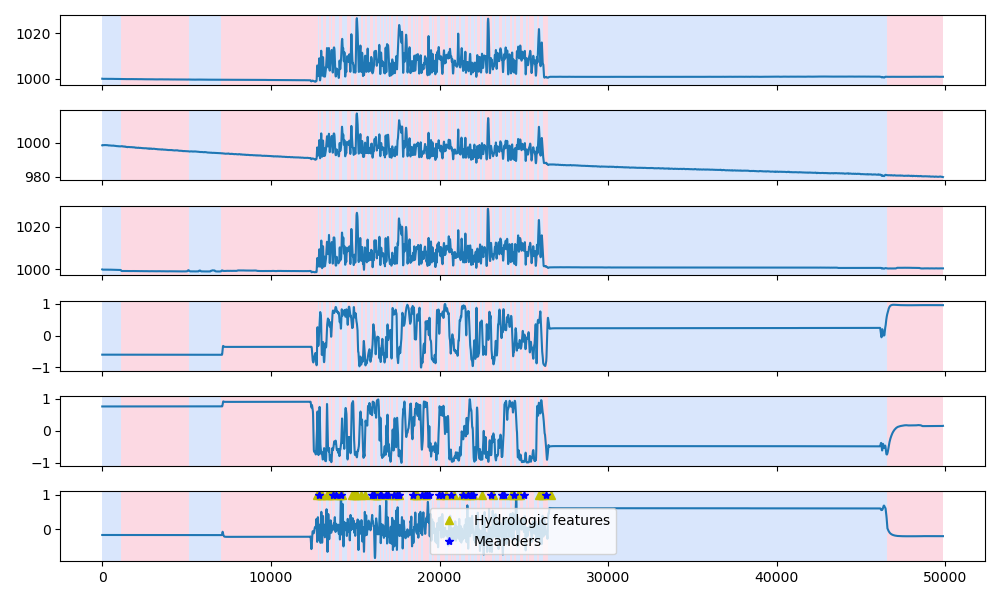

Number of changepoints:  98
Number of manually detected cp:  80


In [121]:
"""B56 A14 A1"""
path_B56="/Users/georgecowie/Documents/Master/Masteroppgave/Master_thesis/MatLab/B56/\B560818162851.csv"
B56_18082020,B56_18082020_low_pass, B56_18082020_n,v_tot = gen_signal(path_B56)
B56_bkps = window_cpd(B56_18082020_low_pass,"ar",width = 100,jump = 10,dim = 3,sigma=0.7)

B56_18082020_start = 12729#B56_bkps[0]#12729
B56_18082020_end = 27149
time_B56_18082020 = time_array(B56_18082020_start,B56_18082020_end)

B56_18082020_vcp = np.array([0.0,1.6,2.5,3.3,6.0,7.5,8.2,10.2,13.3,14.1,15.1,21.1,22.4,23.4,24.2,26.1,28.8,33.4,35.0,36.0,36.1,38.3,42.4,46.1,47.4,49.1,58.4,59.2,59.9,63.8,65.5,73.5,77.4,82.1,87.1,89.0,91.6,93.2,98.6,105.5,111.5,116.4,117.5,120.2,121.8,133.1,134.6,135.7,140.3])
B56_18082020_vcp_idx = index_finder(B56_18082020_vcp,time_B56_18082020,B56_18082020_start)

B56_18082020_meanders = np.array([1.0,9.4,11.7,14.5,33.1,34.0,37.7,38.4,41.5,42.4,46.0,47.7,48.9,57.7,62.7,64.5,65.8,66.9,72.9,74.9,80.4,87.7,90.3,92.0,93.7,104.5,110.6,112.0,117.9,124.2,137.0])
B56_18082020_meanders_idx = index_finder(B56_18082020_meanders,time_B56_18082020,B56_18082020_start)

print("Number of manually detected cp: ",len(B56_18082020_meanders)+ len(B56_18082020_vcp))


plt.plot(B56_18082020_vcp_idx,np.ones(len(B56_18082020_vcp_idx)),marker = "^", color = "y", label = "Hydrologic features",ls = "None")
plt.plot(B56_18082020_meanders_idx,np.ones(len(B56_18082020_meanders_idx)),marker = "*", color = "b", label = "Meanders",ls = "None")
plt.legend()
plt.show()




140818162018
140818162018
[ 8.63210722e-03  1.73951176e-02  2.62328797e-02 ... -4.14331564e+01
 -4.14341403e+01 -4.14351056e+01]


<IPython.core.display.Javascript object>


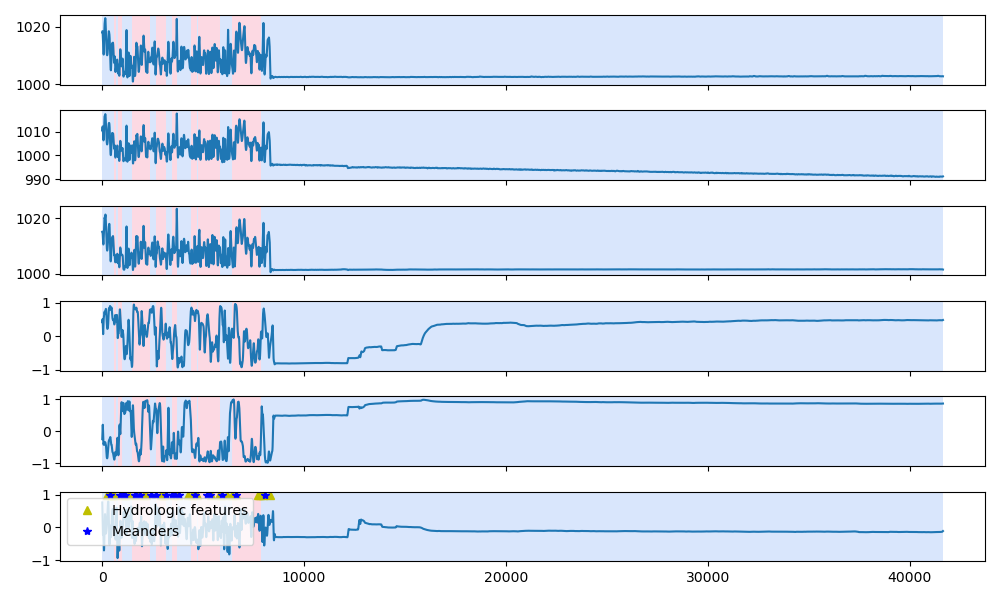

Number of changepoints:  17
Number of manually detected cp:  47


In [123]:
plt.close()
"""B14 A13-A1 
Parts of the beginning of the dataset are missing
The time data of the visually inspected videos have to be manipulated to fit"""
path_B14 = "/Users/georgecowie/Documents/Master/Masteroppgave/Master_thesis/MatLab/B14/A13_A1/r_B140818162018.csv"

B14_18082020, B14_18082020_low_pass,  B14_18082020_n,B14_18082020_v_tot = gen_signal(path_B14)
B14_bkps = window_cpd(B14_18082020,"ar",50,5,4,sigma=1)

B14_18082020_start = 0#B14_bkps[1]#12729
B14_18082020_end = 27149
time_B14_18082020 = time_array(B14_18082020_start,B14_18082020_end)

#B14_18082020_vcp = np.array([0.0,2.2,3.3,9.4,15.6,21.6,23.3,24.3,25.2,29.2,30.6,32.7,36.7,40.2,40.8,48.4,49.3,50.3,55.2,57.0,61.9,64.2,66.5,73.7,77.6,78.7,81.6,85.9,84.0,97.0,98.2,99.8,103.1])
B14_18082020_vcp = np.array([21.6,23.3,24.3,25.2,29.2,30.6,32.7,36.7,40.2,40.8,48.4,49.3,50.3,55.2,57.0,61.9,64.2,66.5,73.7,77.6,78.7,81.6,85.9,84.0,97.0,98.2,99.8,103.1])


B14_18082020_vcp = B14_18082020_vcp#- B14_18082020_vcp[0]
B14_18082020_vcp_idx = index_finder(B14_18082020_vcp,time_B14_18082020,B14_18082020_start)

time_diff = abs(B14_18082020_vcp_idx[-1] - 8315)#make the two datasets fit together by making the ends the same

B14_18082020_vcp_idx = B14_18082020_vcp_idx - time_diff

#B14_18082020_meanders = np.array([0.8,4.7,5.3,8.5,9.6,13.0,14.3,15.3,22.8,28.1,29.7,30.5,35.3,36.2,38.1,43.5,45.9,51.0,53.9,55.6,57.5,65.6,71.4,72.9,79.2,86.0,100.7])
B14_18082020_meanders = np.array([22.8,28.1,29.7,30.5,35.3,36.2,38.1,43.5,45.9,51.0,53.9,55.6,57.5,65.6,71.4,72.9,79.2,86.0,100.7])
B14_18082020_meanders_idx = index_finder(B14_18082020_meanders,time_B14_18082020,B14_18082020_start)

B14_18082020_meanders_idx = B14_18082020_meanders_idx- time_diff

print("Number of manually detected cp: ",len(B14_18082020_meanders)+ len(B14_18082020_vcp))



plt.plot(B14_18082020_vcp_idx,np.ones(len(B14_18082020_vcp_idx)),marker = "^", color = "y", label = "Hydrologic features",ls = "None")
plt.plot(B14_18082020_meanders_idx,np.ones(len(B14_18082020_meanders_idx)),marker = "*", color = "b", label = "Meanders",ls = "None")
plt.legend()
plt.show()


00818171840
00818171840
[5.67041799e-04 1.13408360e-03 1.70112540e-03 ... 1.79175983e+01
 1.79207017e+01 1.79234274e+01]


<IPython.core.display.Javascript object>


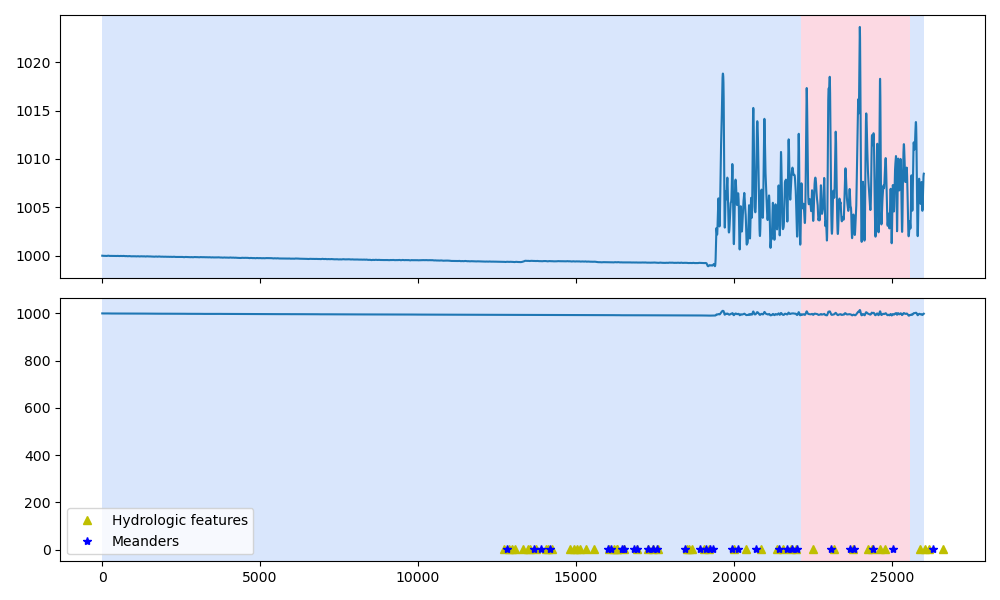

Number of changepoints:  3


In [132]:
"""B80 A15 A1"""
path_B80="/Users/georgecowie/Documents/Master/Masteroppgave/Master_thesis/MatLab/B80/A15_A1/\B800818171840.csv"
B80_18082020_start = 19400#B56_bkps[0]#12729
B80_18082020_end = 29149
time_B80_18082020 = time_array(B80_18082020_start,B80_18082020_end)

B80_A15_18082020_vcp = np.array([0.0,1.6,2.5,3.3,6.0,7.5,8.2,10.2,13.3,14.1,15.1,21.1,22.4,23.4,24.2,26.1,28.8,33.4,35.0,36.0,36.1,38.3,42.4,46.1,47.4,49.1,58.4,59.2,59.9,63.8,65.5,73.5,77.4,82.1,87.1,89.0,91.6,93.2,98.6,105.5,111.5,116.4,117.5,120.2,121.8,133.1,134.6,135.7,140.3])
B80_18082020_vcp_idx = index_finder(B80_18082020_vcp,time_B80_18082020,B80_18082020_start)

B80_18082020_meanders = np.array([1.0,9.4,11.7,14.5,33.1,34.0,37.7,38.4,41.5,42.4,46.0,47.7,48.9,57.7,62.7,64.5,65.8,66.9,72.9,74.9,80.4,87.7,90.3,92.0,93.7,104.5,110.6,112.0,117.9,124.2,137.0,])
#B56_18082020_meanders_idx = index_finder(B56_18082020_meanders,time_B56_18082020,B56_18082020_start)
B80_A1518082020, B80_A1518082020_norm, B80_A1518082020_mean, B80_A1518082020_n = gen_signal(path_B80)


sigma = 1
B80_bkps = window_cpd(B80_A1518082020[:,0:2],"ar",100,10,4,sigma = 2)
plt.plot(B56_18082020_vcp_idx,np.ones(len(B56_18082020_vcp_idx)),marker = "^", color = "y", label = "Hydrologic features",ls = "None")
plt.plot(B56_18082020_meanders_idx,np.ones(len(B56_18082020_meanders_idx)),marker = "*", color = "b", label = "Meanders",ls = "None")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


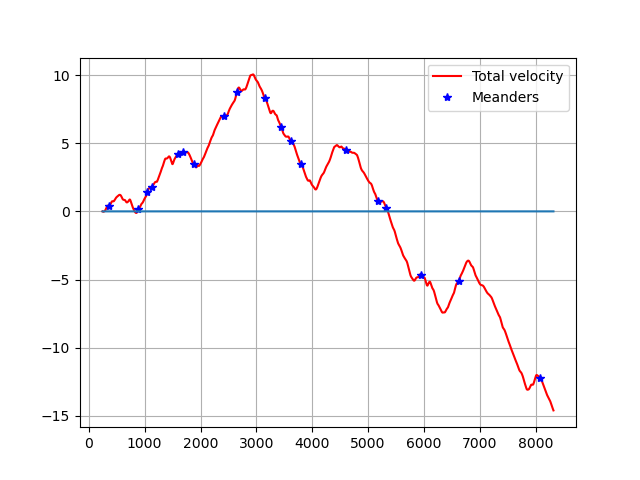

In [126]:
#plot total velocity together with manually registered meanders
def plot_velocity_meanders(meanders,hydraulic_features,tot_vel,offset):
    time_s = np.linspace(hydraulic_features[0],hydraulic_features[-1],abs(hydraulic_features[0]-hydraulic_features[-1]))
    v_0 = tot_vel[hydraulic_features[0]] #start velocity set to 0 where the drifter is deployed
    tot_vel = tot_vel - v_0
    plt.close()
    
    plt.plot(time_s,tot_vel[hydraulic_features[0]:hydraulic_features[-1]],label = "Total velocity",color = "r")
    plt.plot(meanders,np.ones(len(meanders))*tot_vel[meanders],marker = "*", color = "b", label = "Meanders",ls = "None")
    plt.plot(time_s,np.zeros(len(time_s)))
    
    plt.legend()
    plt.grid()
    plt.show()

plot_velocity_meanders(B14_18082020_meanders_idx,B14_18082020_vcp_idx,B14_18082020_v_tot,0)
#plot_velocity_meanders(B56_18082020_meanders_idx,B56_18082020_vcp_idx,v_tot,17.44)